In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/OceanChalenge/ocean_elements_v6.zip
!cp drive/MyDrive/OceanChalenge/elements_dataset.csv .

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Dataset

In [ ]:
PATH = 'drive/MyDrive/OceanChalenge'

In [ ]:
CLASES = ['ripples', 'basura', 'fauna', 'algas', 'roca']

In [ ]:
dataframe = pd.read_csv('elements_dataset.csv')
n = round(len(dataframe) * 0.7)
# separamos el dataset entre datos de entrenamiento (70%) y datos de prueba (30%)
train_data = dataframe.iloc[:n]
test_data = dataframe.iloc[n:]
test_data

,filenames,labels
1764,ocean_elements/algas/cf13b8389c10dc28e5b92f007...,3
1765,ocean_elements/algas/e9c487ccdb88a7d501f0db977...,3
1766,ocean_elements/ripples/48594078a9efb4a5b20180f...,0
1767,ocean_elements/ripples/19a5d2ca15a33ae582bf564...,0
1768,ocean_elements/algas/9c6d06f62473aaee2d15ee949...,3
...,...,...
2515,ocean_elements/algas/330d2bef58bb713889fc575b2...,3
2516,ocean_elements/algas/b87b1d00a63232c839917fc09...,3
2517,ocean_elements/ripples/65708e8c284eeb3a2140f03...,0
2518,ocean_elements/algas/2b43ba08894251ad089d7fd90...,3


In [ ]:
test_files = []
test_labels = []
for filename, label in zip(test_data['filenames'], test_data['labels']):
  if os.path.exists(filename) and filename.split('.')[-1] == 'jpg':
    test_files.append(filename)
    test_labels.append(label)
test_files

In [ ]:
def load_image(filename):
    img = cv2.imread(filename)
    print(f'\r{img.shape}, {filename}', end='')
    img = cv2.resize(img, (480, 270), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.float32(img / 255)
    return img

def load_image_tf(filename):
    image = tf.io.read_file(filename)
    print(f'\r{image.shape}, {filename}', end='')
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [480, 270], method='nearest')
    image = tf.cast(image, tf.float32)
    image = image / 255
    return image

In [ ]:
def random_crop(input_image):
    cropped_image = tf.image.random_crop(
        input_image,
        size=(256, 256, 3))
    return cropped_image

def normalize(input_image):
    input_image = (input_image * 2) - 1
    return input_image

@tf.function()
def random_jitter(input_image, label):
    # randomly cropping to 256 x 256 x 3
    input_image = random_crop(input_image)
    input_image = tf.image.random_brightness(input_image, 0.1)
    input_image = tf.image.random_contrast(input_image, 1, 1.2)
    if tf.random.uniform([1]) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
    input_image = normalize(input_image)
    return input_image, label

(2160, 3840, 3), ocean_elements/algas/cf481599f7959d4cd243651e3a63ab41.jpg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2160, 3840, 3), ocean_elements/ripples/ecd58f380406b1c531fc99dfe62bde8f.jpg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2160, 3840, 3), ocean_elements/algas/a165a6ffbdc0a7631806e3452869bc36.jpg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2160, 3840, 3), ocean_elements/basura/cb8f75f636e309d1943264e0687e4c68.jpg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2160, 3840, 3), ocean_elements/algas/88765357b10770c7e62d67fb00051d8d.jpg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2160, 3840, 3), ocean_elements/basura/ea723871ef4c14423f4abe6513cc17b2.jpg

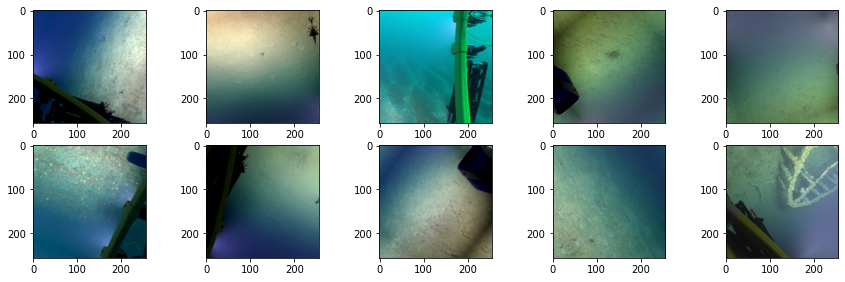

In [ ]:
plt.figure(figsize=(15, 12))
for i in range(10):
    img = load_image(list(test_data['filenames'])[np.random.randint(len(test_data))])
    img, _ = random_jitter(img, None)
    img = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5)(img)
    img = (img + 1) / 2
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
plt.show()

In [ ]:
BATCH_SIZE = 32

In [ ]:
#organiza dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast([load_image(filename) for filename in train_data['filenames']], tf.float32), 
     tf.cast(train_data['labels'], tf.float32))
).map(random_jitter).shuffle(400).repeat().take(10000).batch(BATCH_SIZE)

(2160, 3840, 3), ocean_elements/basura/fb105d07300f546029d0215d56f43884.jpg

In [ ]:
#organiza dataset de testeo
test_dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast([load_image(filename) for filename in test_files], tf.float32), 
     tf.cast(test_labels, tf.float32))
).map(random_jitter).batch(BATCH_SIZE)

(2160, 3840, 3), ocean_elements/fauna/df202a927a6d808262b273e654eda3b2.jpg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


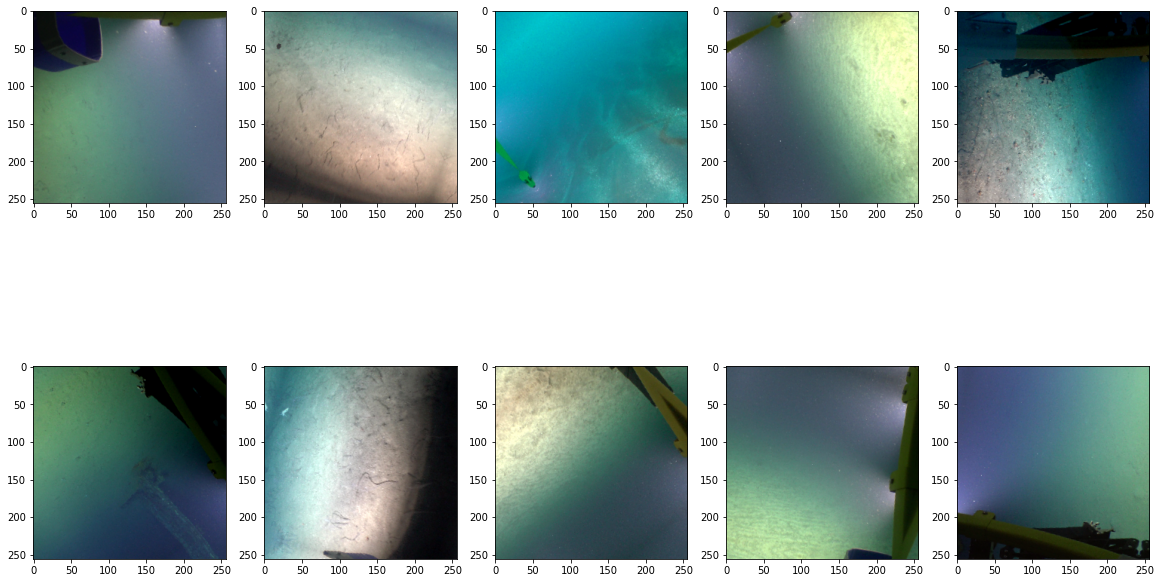

In [ ]:
plt.figure(figsize=(20, 12))
for inp, tar in test_dataset.take(1):
    for i, img in enumerate(inp[:10]):
        img = tf.keras.layers.experimental.preprocessing.RandomRotation(0.5)(img)
        img = (img + 1) / 2
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
plt.show()

In [ ]:
base_model = tf.keras.models.load_model(os.path.join(PATH, 'fondos_model.h5'))

In [ ]:
base_model.trainable = False

In [ ]:
def create_model(): #usa un modelo ya creado (fondos_model.h5) 
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  X = inputs
  for layer in base_model.layers[2:18]:
    X = layer(X)
  X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.Dense(128, activation='relu')(X)
  Y = tf.keras.layers.Dense(len(CLASES))(X)
  model = tf.keras.models.Model(inputs=inputs, outputs=Y)
  return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0     

In [ ]:
model(tf.random.uniform((64, 256, 256, 3))).shape

TensorShape([64, 5])

In [ ]:
import time

In [ ]:
start = time.time()
Y = model(inp)
print(f'time: {time.time() - start}')

time: 0.4881410598754883


In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
with strategy.scope():
    model = create_model()
    optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True,
      reduction=tf.keras.losses.Reduction.NONE)
    loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy('training_loss', dtype=tf.float32)
    acc_metric = tf.keras.metrics.SparseCategoricalAccuracy('training_acc', dtype=tf.float32)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [ ]:
checkpoint_dir = os.path.join(PATH, 'elements_model_checkpoints')
ckpt_prefix = os.path.join(checkpoint_dir, "ckpt")
ckpt = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_prefix, max_to_keep=5)

In [ ]:
manager.restore_or_initialize()

In [ ]:
history_dir = os.path.join(PATH, 'history_elements_training.csv')
if os.path.exists(history_dir):
    history = pd.read_csv(history_dir)
else:
    history = pd.DataFrame()

In [ ]:
@tf.function()
def train_step(X, target):
    with tf.GradientTape() as tape:
        Y = model(X, training=True)
        loss = loss_object(y_true=target, y_pred=Y)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    loss_metric.update_state(target, Y)
    acc_metric.update_state(target, Y)

@tf.function()
def test_step(X, target):
    Y = model(X)
    loss = loss_object(y_true=target, y_pred=Y)
    loss_metric.update_state(target, Y)
    acc_metric.update_state(target, Y)

In [ ]:
def fit(train_dataset, test_dataset, epochs=1, size=10000//BATCH_SIZE):
    global history
    print(f'Modelo restaurado de: {manager.restore_or_initialize()}')
    for epoch in range(epochs):
        start = time.time()
        for step, (X, target) in enumerate(train_dataset):
            strategy.run(train_step, args=(X, target))
            loss = loss_metric.result()
            acc = acc_metric.result()
            print("\rStep: %5d/%d loss: %.3f acc: %.4f" % (step+1, size, loss, acc), end="")
        print(f'\nEpoch: (%3d/%d) Train result | acc: %.3f'
               % (epoch+1, epochs, acc),
              f'| loss: %.5f' % (loss_metric.result()),
              f'| time: %.3f' % (time.time()-start))
        
        if (epoch + 1) % 5 == 0:
            train_loss = loss_metric.result()
            train_acc = acc_metric.result()
            acc_metric.reset_states()
            loss_metric.reset_states()
            for step, (X, target) in enumerate(test_dataset):
                strategy.run(test_step, args=(X, target))
                loss = loss_metric.result()
                acc = acc_metric.result()
                print("\rTest step: %5d/%d loss: %.3f acc: %.4f" 
                      % (step+1, len(test_data) // BATCH_SIZE, loss, acc), end="")
            print(f'\nEpoch: (%3d/%d) Test result | acc: %.3f'
                    % (epoch+1, epochs, acc),
                    f'| loss: %.5f' % (loss_metric.result()),
                    f'| time: %.3f' % (time.time()-start))
            
            history = history.append({
                'epoch': epoch,
                'loss':float(train_loss),
                'acc': float(train_acc),
                'val_loss': float(loss),
                'val_acc': float(acc)}, ignore_index=True)
            history.to_csv(history_dir, index=False)
            seved_dir = manager.save()
            print(f'modelo guardadeo en {seved_dir}')
        acc_metric.reset_states()
        loss_metric.reset_states()

In [ ]:
start = time.time()
strategy.run(train_step, args=(inp, tar))
print(f'time: {time.time() - start}')
loss_metric.result()
#loss_metric.reset_states()

time: 1.2886173725128174


<tf.Tensor: shape=(), dtype=float32, numpy=0.87457323>

In [ ]:
dataset = strategy.experimental_distribute_datasets_from_function(
    lambda _: train_dataset
)

In [ ]:
fit(dataset, test_dataset, epochs=100)

In [ ]:
model.save(os.path.join(PATH, 'elements_clasif_model_v1.h5'))

In [ ]:
model.trainable = True

In [ ]:
fit(dataset, test_dataset, epochs=100)